## Modules

### Import Modules

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch

from transformers import BertTokenizer
from transformers import BertForSequenceClassification, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras_preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
# from pykospacing import Spacing

import pandas as pd
import numpy as np
import random
import time
import datetime

In [ ]:
import os

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


## Data Load & Preprocessing


### Load Data

In [ ]:
my_path = '/content' #colab 업로드 기준, 자유롭게 변경해주세용.
project_path = '/content/sharing'

def load_data(dir, file_name):
  df = pd.read_csv(os.path.join(dir,file_name), sep=",",encoding ='cp949')
  return df

train_raw = load_data(my_path, '모음집.csv')

#학습에 사용할 데이터
train_df = train_raw.copy()
train_df = train_df[['reple','star_score']]
display(train_df.head(10))

,reple,star_score
0,유해진과 류준열 두 배우의 광기가 가득찬 연기로 118분간 스크린을 제대로 찢어놓은...,10
1,진짜 재밌음... 믿고보는 유해진 류준열 모든 배우연기는 말해 뭐함 너무 잘함,10
2,연출이 정말 미쳤어요.. 입봉작이라던데 앞으로가 기대되는 감독입니다,9
3,미쳤다.... 블랙팬서로 받은 상처 한번에 치유댐.... 어쩌다 외국 대작으로 상처...,10
4,배우들이 연기를 잘해서 몰입도가 상당하네요! 재밌게 봤어요!,10
5,2022년 하반기 최고영화 완전잼있어요,10
6,팩션 사극과 스릴러의 옳은 만남,10
7,사극인데 이렇게 흥미 진진한게 가능하네요 너무 재밌어요 중후반부에 미친,10
8,정말 재밌습니다 오랜만에 시간가는줄 모르고 봤네요,10
9,"스토리, 배우들의 연기력 모두 대박 너무 재밌다",10


<ipython-input-11-f24bcbde3ab5>:21: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['reple'] = train_df['reple'].str.replace("[^ㄱ-ㅎ가-힣 ]","")


,star_score,count
0,1,17770
1,2,9410
2,3,13084
3,4,15492
4,5,20810


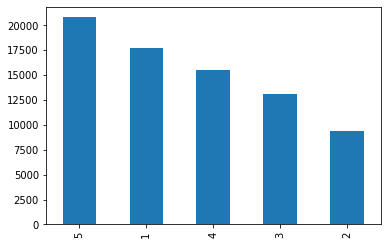

In [ ]:
###########################################################################
#                     이 셀은 한번만 실행해야 합니당                      #
###########################################################################

# star_score 점수 1~5 사이의 값으로 변환
def transform_score(score):
  return {
      10 : 5,
      9 : 5,
      8 : 4,
      7 : 4,
      6 : 3,
      5 : 3,
      4 : 2,
      3 : 2,
      2 : 1,
      1 : 1,   
  }.get(score, -1)

#한글과 공백을 제외하고 모두 제거
train_df['reple'] = train_df['reple'].str.replace("[^ㄱ-ㅎ가-힣 ]","")

train_df['reple'].apply

# spacing = Spacing()

# for i in range(len(train_df['reple'])):
#   train_df['reple'][i] = spacing(train_df['reple'][i])

#star_score 점수 변환
train_df['star_score'] = train_df['star_score'].apply(lambda train_df: transform_score(train_df))
train_df['star_score'].value_counts().plot(kind = 'bar')
train_df.groupby('star_score').size().reset_index(name = 'count')

### Split data into Train & Test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df['reple'], train_df['star_score'], random_state=42, test_size=0.2)

print('=============================================================================================')
print('#========================== 나눈 DataFrame의 크기,분포 확인 ===============================#')
print('=============================================================================================')

print(f"Training Data Size : {len(X_train)}")
display(X_train.head(10))
print(f"Testing Data Size : {len(X_test)}")
display(X_test.head(10))
print('\n')

#========================== 나눈 DataFrame의 크기,분포 확인 ===============================#
Training Data Size : 61252


18699    아 관람평을 믿을걸 싶다 극장안의 공기가 너무 무거워서 주변을 몇번이나 살폈는지 모르겠다
1059                                          믿고 보는 연기 재밌다
29413                                  액션이 재밌긴 한데 실망 많이했어여
29834                               비현실과 현실사이에 태어난 멋쟁이 히어로
4098                                           비상선언보다 못한영화
6896     영화에서 불필요하게 욕설 많이 하는 경우는 거부감이 들어요 배성우 특히 왤케 불필요...
34679                                    내가볼땐 이영화 알바들 너무많다
55546                             저는 나름 괜찮았는데ㅋ 힘내시라고 점드려요ㅋ
21210                            더도말고 덜도 말고  많이 들어간 어린이 영화
72570    좀 어렵다 내용에 담긴 의미를 파악해야하는데 딱 떨어지는 스토리 중요시하시는 분 비...
Name: reple, dtype: object

Testing Data Size : 15314


16354    욕은 안하겠지만 욕나오게 시간 돈 다 아깝습니다 안보시길 제발 여기 댓글들 다 알바입니다
49870                                           다보고 몸에 힘풀림
22989                                        개노잼이야 ㅅㅂ어라ㄴㅁㅇ
41315                                         어린이들이 너무 많았다
75428    삶은 변절하지 않는다 틀렸고 맞으나 상응하는 결과는 언제나 같다 찬찬히 부는 바람을...
21489                          볼까말까 고민하다가 봤는데 ㅋㅋ 역시 봐야해 ㅋㅋ
22206    전편들만큼 재밌지는 않았어요 원래 트랜스포머를 너무 좋아해서 그런지 기대하고 봤는데...
55434                                    일부러 이렇게 만들기도 힘들겠다
63587    몇번을다시봐도 또 설레네 강동원은다시봐도잘생기고 조한선도 멋있네 이청아는 귀욤풋풋한영화임
68180    이때 까지 본 영화중 가장 재미없는 영화입니다 후반에 반전이 있을 거란 기대감만 올...
Name: reple, dtype: object

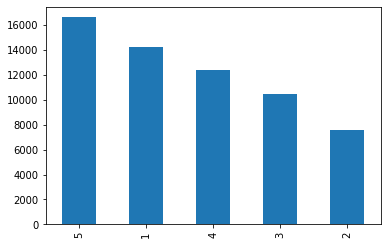

In [ ]:
y_train.value_counts().plot(kind = 'bar')

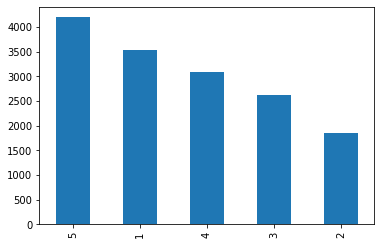

In [ ]:
y_test.value_counts().plot(kind = 'bar')

### Review Tokenizing

In [ ]:
document_bert = ["[CLS] " + str(s) + " [SEP]" for s in X_train]
document_bert[:5]

['[CLS] 아 관람평을 믿을걸 싶다 극장안의 공기가 너무 무거워서 주변을 몇번이나 살폈는지 모르겠다 [SEP]',
 '[CLS] 믿고 보는 연기 재밌다 [SEP]',
 '[CLS] 액션이 재밌긴 한데 실망 많이했어여 [SEP]',
 '[CLS] 비현실과 현실사이에 태어난 멋쟁이 히어로 [SEP]',
 '[CLS] 비상선언보다 못한영화 [SEP]']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in document_bert]
print(tokenized_texts[0])

Downloading:   0%|          | 0.00/996k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

['[CLS]', '아', '관', '##람', '##평', '##을', '믿', '##을', '##걸', '싶', '##다', '극', '##장', '##안', '##의', '공', '##기가', '너', '##무', '무', '##거', '##워', '##서', '주', '##변', '##을', '몇', '##번', '##이나', '[UNK]', '모', '##르', '##겠', '##다', '[SEP]']


### Padding

In [ ]:
MAX_LEN = 128
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype='long', truncating='post', padding='post')
input_ids[0]

array([   101,   9519,   8900,  61250, 119398,  10622,   9312,  10622,
       118624,   9495,  11903,   8925,  13890,  34951,  10459,   8896,
        47869,   9004,  32537,   9294,  41521,  69592,  12424,   9689,
       118985,  10622,   9282,  35465,  43739,    100,   9283,  31401,
       118632,  11903,    102,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
            0,      0,      0,      0,      0,      0,      0,      0,
      

In [ ]:
attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
    
print(attention_masks[0])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, y_train.values, random_state=42, test_size=0.1)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, 
                                                       input_ids,
                                                       random_state=42, 
                                                       test_size=0.1)

In [ ]:
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)

In [ ]:
BATCH_SIZE = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=BATCH_SIZE)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=BATCH_SIZE)

In [ ]:
sentences = X_test
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
labels = y_test.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

test_inputs = torch.tensor(input_ids)
test_labels = torch.tensor(labels)
test_masks = torch.tensor(attention_masks)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = RandomSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=BATCH_SIZE)

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Define BERT Model

In [ ]:
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=2) #긍정,부정
model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=6) #평점 1~3점
model.cuda()

Downloading:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [ ]:
# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 epsilon 값
                )

# 에폭수
epochs = 4

# 총 훈련 스텝
total_steps = len(train_dataloader) * epochs

# lr 조금씩 감소시키는 스케줄러
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# 정확도 계산 함수
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# 시간 표시 함수
def format_time(elapsed):
    # 반올림
    elapsed_rounded = int(round((elapsed)))
    # hh:mm:ss으로 형태 변경
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# 재현을 위해 랜덤시드 고정
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# 그래디언트 초기화
model.zero_grad()

# 에폭만큼 반복
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # 시작 시간 설정
    t0 = time.time()

    # 로스 초기화
    total_loss = 0

    # 훈련모드로 변경
    model.train()
        
    # 데이터로더에서 배치만큼 반복하여 가져옴
    for step, batch in enumerate(train_dataloader):
        # 경과 정보 표시
        if step % 500 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch

        # Forward 수행                
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels)
        
        # 로스 구함
        loss = outputs[0]

        # 총 로스 계산
        total_loss += loss.item()

        # Backward 수행으로 그래디언트 계산
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 그래디언트를 통해 가중치 파라미터 업데이트
        optimizer.step()

        # 스케줄러로 학습률 감소
        scheduler.step()

        # 그래디언트 초기화
        model.zero_grad()

    # 평균 로스 계산
    avg_train_loss = total_loss / len(train_dataloader)            

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    #시작 시간 설정
    t0 = time.time()

    # 평가모드로 변경
    model.eval()

    # 변수 초기화
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # 데이터로더에서 배치만큼 반복하여 가져옴
    for batch in validation_dataloader:
        # 배치를 GPU에 넣음
        batch = tuple(t.to(device) for t in batch)
        
        # 배치에서 데이터 추출
        b_input_ids, b_input_mask, b_labels = batch
        
        # 그래디언트 계산 안함
        with torch.no_grad():     
            # Forward 수행
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # 로스 구함
        logits = outputs[0]

        # CPU로 데이터 이동
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # 출력 로짓과 라벨을 비교하여 정확도 계산
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch   500  of  1,723.    Elapsed: 0:06:05.
  Batch 1,000  of  1,723.    Elapsed: 0:12:14.
  Batch 1,500  of  1,723.    Elapsed: 0:18:23.

  Average training loss: 1.29
  Training epcoh took: 0:21:07

Running Validation...
  Accuracy: 0.52
  Validation took: 0:00:47

======== Epoch 2 / 4 ========
Training...
  Batch   500  of  1,723.    Elapsed: 0:06:09.
  Batch 1,000  of  1,723.    Elapsed: 0:12:18.
  Batch 1,500  of  1,723.    Elapsed: 0:18:26.

  Average training loss: 1.10
  Training epcoh took: 0:21:10

Running Validation...
  Accuracy: 0.53
  Validation took: 0:00:47

======== Epoch 3 / 4 ========
Training...
  Batch   500  of  1,723.    Elapsed: 0:06:08.
  Batch 1,000  of  1,723.    Elapsed: 0:12:16.
  Batch 1,500  of  1,723.    Elapsed: 0:18:23.

  Average training loss: 1.00
  Training epcoh took: 0:21:07

Running Validation...
  Accuracy: 0.53
  Validation took: 0:00:47

======== Epoch 4 / 4 ========
Training...
  Batch   500  of 

In [ ]:
# save the trained model
PATH = './net_pretrained.pth'
torch.save(model.state_dict(), PATH)

##  Test Model

In [ ]:
# model = BertForSequenceClassification.from_pretrained("bert-base-multilingual-cased", num_labels=6)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(test_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(test_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask, b_labels = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    # 출력 로짓과 라벨을 비교하여 정확도 계산
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))

  Batch   100  of    479.    Elapsed: 0:00:22.
  Batch   200  of    479.    Elapsed: 0:00:44.
  Batch   300  of    479.    Elapsed: 0:01:07.
  Batch   400  of    479.    Elapsed: 0:01:30.

Accuracy: 0.54
Test took: 0:01:49


## Predict star score

In [ ]:
!curl -s https://raw.githubusercontent.com/teddylee777/machine-learning/master/99-Misc/01-Colab/mecab-colab.sh | bash 

--2022-12-02 17:40:43--  https://www.dropbox.com/s/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.85.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.85.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz [following]
--2022-12-02 17:40:43--  https://www.dropbox.com/s/dl/9xls0tgtf3edgns/mecab-0.996-ko-0.9.2.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb29bff2c216e1ccaa1fa08afde.dl.dropboxusercontent.com/cd/0/get/Bx0b4LOZoBZ5P3UNcdOiJkZhnBJKmntyWBD33VwHdfUNpbctbXsOXr2FN6W8XdYnlR2jVYc4JBa-qXyOK9gaaUTZg8JwUmMYCsD0Zr4SYVjYZFkmReiD_1l0GH3qP0GaxXJwjf9dTq1zsZepGri6JllUlFdz2NWUHVdIK6tvcwZV4tBUJlX5SBvTHkkbBYZKemI/file?dl=1# [following]
--2022-12-02 17:40:44--  https://ucb29bff2c216e1ccaa1fa08afde.dl.dropboxusercontent.com/cd/0/get/Bx0b4LOZo

In [ ]:
from konlpy.tag import Okt, Mecab

Okt = Okt()

Okt.morphs('한글 형태소 분석기(오케이티)로 테스트를 해보았습니다. 정상 설치 및 동작이 잘 됩니다.')

['한글',
 '형태소',
 '분석',
 '기',
 '(',
 '오',
 '케이티',
 ')',
 '로',
 '테스트',
 '를',
 '해보았습니다',
 '.',
 '정상',
 '설치',
 '및',
 '동작',
 '이',
 '잘',
 '됩니다',
 '.']

In [ ]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
pred_raw = load_data(my_path, 'result_movie3.csv') #평점 예측할 영화의 SNS Review 데이터

#학습에 사용할 데이터
pred_df = pred_raw.copy()
pred_df = pred_df[['reple']]
display(pred_df)

,reple
0,(24시간 무수면)오랜만에 뼈 삭는 느낌HP 깎이는 느낌음~ 굿~.. 이거 아직 안...
1,애초에 아이언맨 3에 나온 정비공 꼬마가 제2의 아이언맨 자리를 물려받고 저 아이언...
2,"영화를 쭉보면서 슈리가 사물이던,사람이던 살릴수 있어.. 고칠수 있어.. 이렇게 집..."
3,킬몽거 서사를 버리지 않고 활용했다는 것에서 진짜 박수를 보냄! 성경 속 뱀 같은 ...
4,기존 주연배우가 갑자기 사망하는 바람에 어쩔수 없이 노선변경을 해서 매끄럽지 못한 ...
...,...
239,평가들을 보니까 앤트맨3를 존버해야겟네요
240,단순 디자인만 놓고봐도... 아이언맨이 카봇이 돼버렸어 ㅠㅠ
241,오늘이 벌써 개봉일이었구나
242,영화가 끝나자 제 뒤에 앉아있던 관객의 한마디 ''마블 망해라 XXX'' 였습니다....


<ipython-input-118-1000f11df25d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_df['reple'] = pred_df['reple'].str.replace("[^ㄱ-ㅎ가-힣 ]","")


In [ ]:
pred_df['reple'] = pred_df['reple'].str.replace("[^ㄱ-ㅎ가-힣 ]","")
pred_df['reple'].apply

X_pred = pred_df['reple']
display(X_pred)

BATCH_SIZE = 32

<ipython-input-119-4cf209e768d1>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  pred_df['reple'] = pred_df['reple'].str.replace("[^ㄱ-ㅎ가-힣 ]","")


0      시간 무수면오랜만에 뼈 삭는 느낌 깎이는 느낌음 굿 이거 아직 안 보신 분블랙팬서 ...
1      애초에 아이언맨 에 나온 정비공 꼬마가 제의 아이언맨 자리를 물려받고 저 아이언하트...
2      영화를 쭉보면서 슈리가 사물이던사람이던 살릴수 있어 고칠수 있어 이렇게 집착하는 인...
3      킬몽거 서사를 버리지 않고 활용했다는 것에서 진짜 박수를 보냄 성경 속 뱀 같은 포...
4      기존 주연배우가 갑자기 사망하는 바람에 어쩔수 없이 노선변경을 해서 매끄럽지 못한 ...
                             ...                        
239                                평가들을 보니까 앤트맨를 존버해야겟네요
240                         단순 디자인만 놓고봐도 아이언맨이 카봇이 돼버렸어 
241                                       오늘이 벌써 개봉일이었구나
242    영화가 끝나자 제 뒤에 앉아있던 관객의 한마디 마블 망해라  였습니다그 한마디가 현...
243        다음편에 네이머가 슈리 죽이고 트찰라 아들 컸다는 설정으로 다시하는게 ㄹㅇ 좋을듯
Name: reple, Length: 244, dtype: object

In [ ]:
sentences = X_pred
sentences = ["[CLS] " + str(sentence) + " [SEP]" for sentence in sentences]
sentences[:5]

['[CLS] 시간 무수면오랜만에 뼈 삭는 느낌 깎이는 느낌음 굿 이거 아직 안 보신 분블랙팬서 와칸다 포에버 충격적인 스토리 유출 루머 총정리 [SEP]',
 '[CLS] 애초에 아이언맨 에 나온 정비공 꼬마가 제의 아이언맨 자리를 물려받고 저 아이언하트 위치에 토니의 딸이 들어갔어야 한다고봄 그렇게 해서 페이즈 에서 토니 부부 처럼 듀오로 같이 싸우는게 더 개연성 있다고 생각함 [SEP]',
 '[CLS] 영화를 쭉보면서 슈리가 사물이던사람이던 살릴수 있어 고칠수 있어 이렇게 집착하는 인물이라는걸 쭉보여주는데그걸 다보고 첫장면을 떠올리면 오빠의 죽음을 막을수 없었던 슈리가 얼마나 절박했는지 이해가 됨 [SEP]',
 '[CLS] 킬몽거 서사를 버리지 않고 활용했다는 것에서 진짜 박수를 보냄 성경 속 뱀 같은 포지션 정말 갠취였음 ㅋㅋㅋ [SEP]',
 '[CLS] 기존 주연배우가 갑자기 사망하는 바람에 어쩔수 없이 노선변경을 해서 매끄럽지 못한 부분도 있었지만 재미를 떠나 감독이 정말 최선을 다했다는게 느껴짐 시간반짜리 생각보다 지루하지않은 채드윅 보스만의 장례식같은 영화 네이머같은 매력적인 빌런의 등장도 좋았고 슈리의 블랙팬서 주연 승계에 대해선 전혀 불만없지만 생각보다 별볼일 없는 액션 없는게 나았을 아이언하트 및 리리윌리암스는 하 영화 진행을 위해 억지로 끼워놓은 느낌 [SEP]']

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)
tokenized_texts = [tokenizer.tokenize(s) for s in sentences]
print(tokenized_texts[0])

['[CLS]', '시', '##간', '무', '##수', '##면', '##오', '##랜', '##만', '##에', '뼈', '삭', '##는', '느', '##낌', '깎', '##이는', '느', '##낌', '##음', '굿', '이', '##거', '아', '##직', '안', '보', '##신', '분', '##블', '##랙', '##팬', '##서', '와', '##칸', '##다', '포', '##에', '##버', '충', '##격', '##적인', '스', '##토', '##리', '유', '##출', '루', '##머', '총', '##정', '##리', '[SEP]']


In [ ]:
MAX_LEN = 128

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

attention_masks = []

for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

pred_inputs = torch.tensor(input_ids)
pred_masks = torch.tensor(attention_masks)

pred_data = TensorDataset(pred_inputs, pred_masks)
pred_sampler = RandomSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=BATCH_SIZE)

In [ ]:
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
predicted_label = []

In [ ]:
#시작 시간 설정
t0 = time.time()

# 평가모드로 변경
model.eval()

# 변수 초기화
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

# 데이터로더에서 배치만큼 반복하여 가져옴
for step, batch in enumerate(pred_dataloader):
    # 경과 정보 표시
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(pred_dataloader), elapsed))

    # 배치를 GPU에 넣음
    batch = tuple(t.to(device) for t in batch)
    
    # 배치에서 데이터 추출
    b_input_ids, b_input_mask = batch
    
    # 그래디언트 계산 안함
    with torch.no_grad():     
        # Forward 수행
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)

    # 로스 구함
    logits = outputs[0]

    # CPU로 데이터 이동
    logits = logits.detach().cpu().numpy()
    input_masks = b_input_mask.to('cpu').numpy()

    for logit in logits:
      pred = np.argmax(logit)
      predicted_label.append(pred)

In [ ]:
predicted_df = pd.DataFrame({'reple': X_pred, 'predicted_label': predicted_label})

In [ ]:
predicted_df['predicted_label'] = predicted_df.predicted_label.astype(str)

In [ ]:
predicted_df.to_csv('prediction_result.csv', index=False)